# Test Episcanpy Gene Annotation

This Notebook explores episcanpy's find_genes function

## 1. Imports

In [1]:
import os.path
import tempfile
from collections import defaultdict

import anndata as ad
import episcanpy as epi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

## 2. Calling find_genes on an example tissue, esophagus muscularis

### 2.1. Constants

In [2]:
h5ad_path = "/mnt/workspace_stud/mbentse/catlas_objects/esophagus_muscularis_SM-A8CPH.h5ad"

data_folder="/mnt/workspace_stud/allstud/wp1/data/"

gtf_url="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz"
gtf_filename="gencode.v38.annotation.gtf"

### 2.2. Download gene annotations (hg38)

In [3]:
# Check if the file exists in the 'data' folder
if os.path.exists(f"{data_folder}/{gtf_filename}"):
    print(f"{gtf_filename} already exists in the data folder.")
else:
    print(f"Downloading {gtf_filename}...")
    # Use ! to execute the Bash command directly
    !wget -qO- {gtf_url} | gunzip > {data_folder}/{gtf_filename}
    print(f"Download and extraction of {gtf_filename} complete.")

gencode.v38.annotation.gtf already exists in the data folder.


### 2.3. Read h5ad files and build anndata objects

In [4]:
adata = epi.read_h5ad(h5ad_path)

### 2.4. Rename var index from chr1:from-to to chr1_from_to

In [5]:
index = list()
for n in adata.var_names.tolist():
    parts = n.replace('-', '_').replace(':', '_').split('_')
    # sometimes there are extra informations in this format, only read chrom, from and to
    index.append("_".join((parts[0], parts[-2], parts[-1])))
adata.var_names = pd.Index(index)

In [6]:
adata.var

""
chr1_9955_10355
chr1_29163_29563
chr1_79215_79615
chr1_102755_103155
chr1_180580_180980
...
chrY_56676947_56677347
chrY_56677442_56677842
chrY_56678029_56678429
chrY_56678600_56679000


### 2.5. call find_genes

The parameters are taken from the episcan tutorial on scATAC-Seq
https://nbviewer.org/github/colomemaria/epiScanpy/blob/master/docs/tutorials/Buenrostro_PBMC_data_processing.html

We should try our own parameters later.

In [7]:
%%time
epi.tl.find_genes(adata,
           gtf_file=f"{data_folder}/{gtf_filename}",
           key_added='gene_annotation',
           upstream=2000,
           feature_type='gene',
           annotation='HAVANA',
           raw=False)

CPU times: user 1min 20s, sys: 1.27 s, total: 1min 21s
Wall time: 1min 21s


This runs for quite some time.

## 3. Explore the annotations by plotting

### 3.1. prepare data, sum gene by count

In [8]:
split_genes = adata.var['gene_annotation'].str.split(';')

In [9]:
split_genes[:10]

chr1_9955_10355                      [DDX11L1]
chr1_29163_29563         [MIR1302-2HG, WASH7P]
chr1_79215_79615                  [intergenic]
chr1_102755_103155              [RP11-34P13.7]
chr1_180580_180980                  [DDX11L17]
chr1_181273_181673                  [DDX11L17]
chr1_184281_184681                [intergenic]
chr1_185527_185927                    [WASH9P]
chr1_191294_191694                    [WASH9P]
chr1_267803_268203    [AP006222.3, AP006222.1]
Name: gene_annotation, dtype: object

In [10]:
flattened_data = []
for index, genes in split_genes.items():
    for gene in genes:
        flattened_data.append([index, gene])

In [11]:
flattened_data[:10]

[['chr1_9955_10355', 'DDX11L1'],
 ['chr1_29163_29563', 'MIR1302-2HG'],
 ['chr1_29163_29563', 'WASH7P'],
 ['chr1_79215_79615', 'intergenic'],
 ['chr1_102755_103155', 'RP11-34P13.7'],
 ['chr1_180580_180980', 'DDX11L17'],
 ['chr1_181273_181673', 'DDX11L17'],
 ['chr1_184281_184681', 'intergenic'],
 ['chr1_185527_185927', 'WASH9P'],
 ['chr1_191294_191694', 'WASH9P']]

In [12]:
flattened_df = pd.DataFrame(flattened_data, columns=['region', 'gene'])

In [13]:
flattened_df

,region,gene
0,chr1_9955_10355,DDX11L1
1,chr1_29163_29563,MIR1302-2HG
2,chr1_29163_29563,WASH7P
3,chr1_79215_79615,intergenic
4,chr1_102755_103155,RP11-34P13.7
...,...,...
1305549,chrY_56676947_56677347,unassigned
1305550,chrY_56677442_56677842,unassigned
1305551,chrY_56678029_56678429,unassigned
1305552,chrY_56678600_56679000,unassigned


In [14]:
gene_counts = flattened_df.groupby('gene').count()
gene_counts.rename(columns={'region': 'region_count'}, inplace=True)

In [15]:
gene_counts

,region_count
gene,
A1BG,6
A1BG-AS1,6
A1CF,32
A2M,25
A2M-AS1,3
...,...
bP-2189O9.5,5
hsa-mir-423,1
intergenic,336628


Noticing a lot of intergenic regions. We don't want to plot these. Maybe we should explore other settings for find_genes to annotate more regions, i.e. increase upstream, downstream, choose another annotation

In [16]:
print(f'intergenic: {gene_counts.loc["intergenic"]["region_count"]}')
print(f'unassigned: {gene_counts.loc["unassigned"]["region_count"]}')

intergenic: 336628
unassigned: 5


In [17]:
# Drop 'intergenic' and 'unassigned' annotations
gene_counts = gene_counts.drop("intergenic")
gene_counts = gene_counts.drop("unassigned")

### 3.2. Plot Top 80 Genes by region count

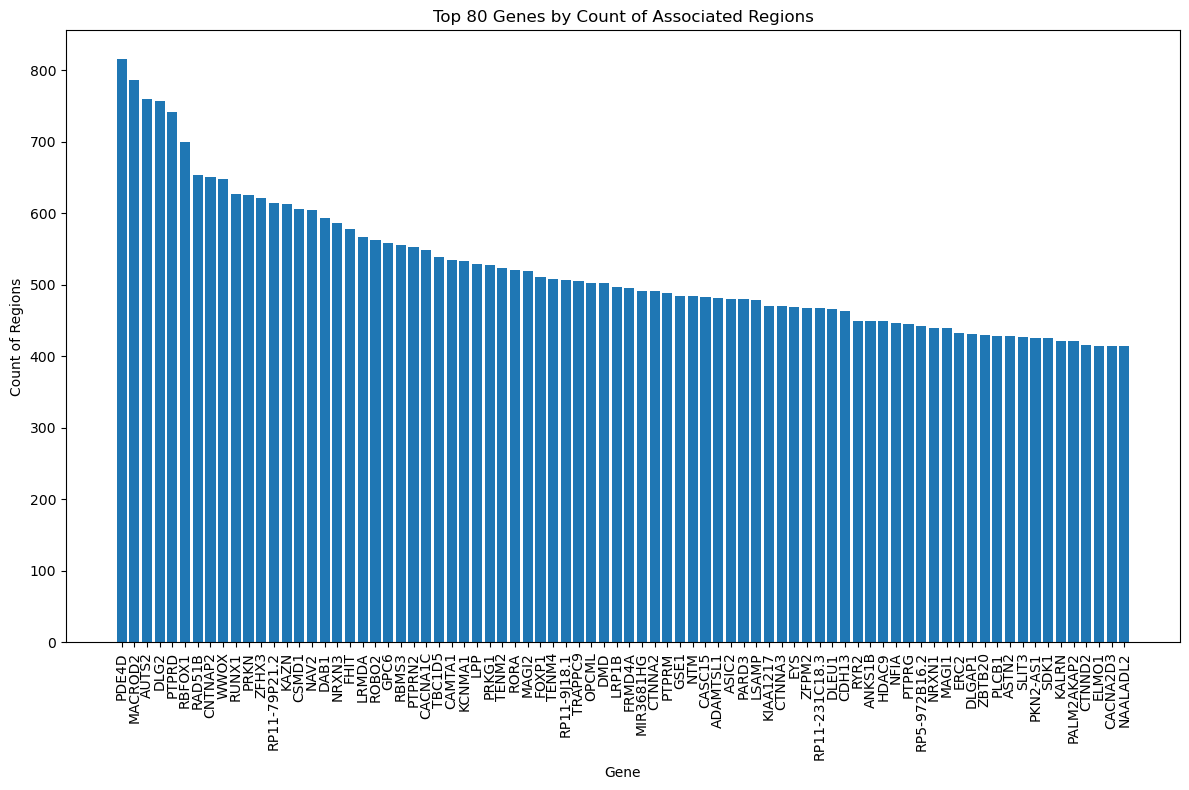

In [18]:
top_n = 80
gene_counts_sorted = gene_counts.sort_values(by="region_count", ascending=False).head(top_n)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(gene_counts_sorted.index, gene_counts_sorted["region_count"])
plt.xticks(rotation=90)
plt.xlabel("Gene")
plt.ylabel("Count of Regions")
plt.title(f"Top {top_n} Genes by Count of Associated Regions")
plt.tight_layout()
plt.show()

I looked up some of these genes, they all seem important in a lot of cells. So it looks like this data was generally correctly loaded

### 3.3. Plot Distribution (Histogram) of region_count per gene_annotation

<Figure size 1200x600 with 0 Axes>

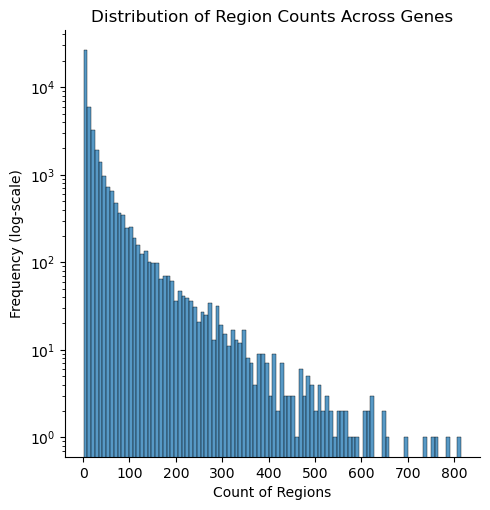

In [19]:
plt.figure(figsize=(12, 6))
sns.displot(gene_counts["region_count"], kind='hist', log_scale=(False, True), bins=100)
plt.xlabel("Count of Regions")
plt.ylabel("Frequency (log-scale)")
plt.title("Distribution of Region Counts Across Genes")
plt.show()

This data is log plotted

The data looks reasonable, some genes associated with a lot of regions, most genes only with a few.

## 4. Speeding up find_genes

Since find_genes takes quite some time (over a minute) this hinders experimentation. find_gene implements a O(N x M) lookup. We can trivially reduce that to O(N + M).

We later want to test different parameters of find_genes quickly.

### 4.1. Define my_find_genes

In [20]:
# keep the same parameters and default values as epi.tl.find_genes,
# but dropping the raw parameter since it is not even used in episcanpy's find_genes
def my_find_genes(adata,
        gtf_file,
        feature_type='gene',
        annotation='HAVANA',
        upstream=5000,
        downstream=0,
        key_added="gene_annotation"):

    def extract_gene_name(attributes):
        attributes_list = attributes.split(';')
        for attribute in attributes_list:
            if 'gene_name' in attribute:
                return attribute.split('"')[1].strip()
        raise KeyError("'gene_name' not found in gtf attributes")
    
    def parse_region(region):
        if ':' in region and '-' in region:
            chrom, positions = region.split(':')
            begin, end = map(int, positions.split('-'))
        elif '_' in region:
            chrom, begin, end = region.split('_')
            begin, end = int(begin), int(end)
        else:
            raise ValueError(f"Invalid region format: {region}")
        return chrom, begin, end

    genes = defaultdict(list)
    with open(gtf_file) as f:
        for line in f:
            # skip comment lines
            if line.startswith('#'):
                continue
            
            # gtf data is tab separated
            fields = line.strip().split('\t')
            
            # only read lines with the correct source and feature_type 
            if fields[1] != annotation or fields[2] != feature_type:
                continue

            chrom = fields[0]
            start = int(fields[3])
            end = int(fields[4])
            strand = fields[6]
            attributes = fields[8]
            gene_name = extract_gene_name(attributes)

            if strand == '+':
                adjusted_start = start - upstream
                adjusted_end = end + downstream
            else:
                adjusted_start = start - downstream
                adjusted_end = end + upstream

            genes[chrom].append((adjusted_start, adjusted_end, gene_name))
    genes = dict(genes) # defaultdict -> dict

    # Since we add upstream and downstream offsets, the list might be unsorted
    for chrom in genes:
        # sort by start
        genes[chrom].sort(key=lambda x: x[0])


    # Group and sort regions by chromosome
    regions = defaultdict(list)
    for region in adata.var_names.tolist():
        chrom, start, end = parse_region(region)
        regions[chrom].append((start, end, region))

    for chrom in regions:
        # sort by start
        regions[chrom].sort(key=lambda x: x[0])
        
    # Perform a merge-like operation for each chromosome
    gene_annotations = defaultdict(set)
    for chrom in regions:
        rs = regions[chrom]
        try:
            gs = genes[chrom]
        except KeyError:
            # chromosome not found in gtf
            for region in rs:
                gene_annotations[region[2]] = ['unassigned']
            continue
        
        gene_pointer, region_pointer = 0, 0
        while gene_pointer < len(gs) and region_pointer < len(rs):
            gene_start, gene_end, gene_name = gs[gene_pointer]
            region_start, region_end, region_name = rs[region_pointer]

            if gene_end < region_start:
                # Move to the next gene
                gene_pointer += 1
            elif gene_start > region_end:
                # Move to the next region
                region_pointer += 1
            else:
                # Overlap detected
                gene_annotations[region_name].add(gene_name)
                
                # look through all regions after region_pointer, then go to next gene
                region_pointer2 = region_pointer + 1
                while region_pointer2 < len(rs):
                    region_start2, region_end2, region_name2 = rs[region_pointer2]
                    if gene_end < region_start2:
                        break
                    gene_annotations[region_name2].add(gene_name)
                    region_pointer2 += 1
                gene_pointer += 1

    # label unannotated regions as intergenic
    all_gene_annotations = dict()
    for chrom in regions:
        for _region_start, _region_end, region_name in regions[chrom]:
            annotation = gene_annotations[region_name]
            annotation = ";".join(sorted(annotation)) if len(annotation) > 0 else 'intergenic'
            all_gene_annotations[region_name] = annotation
            
    # Update adata
    update_df = pd.DataFrame.from_dict(all_gene_annotations, orient='index')
    adata.var[key_added] = update_df

In [21]:
%%time
my_find_genes(adata,
            gtf_file=f"{data_folder}/{gtf_filename}",
            key_added='my_gene_annotation',
            upstream=2000,
            feature_type='gene',
            annotation='HAVANA')

CPU times: user 9.43 s, sys: 784 ms, total: 10.2 s
Wall time: 10.2 s


This runs a lot faster. This is even more noticable between transcripts, we look into these later

### 4.2. Testing for correctness

In [22]:
adata.var["gene_annotation"]

chr1_9955_10355                      DDX11L1
chr1_29163_29563          MIR1302-2HG;WASH7P
chr1_79215_79615                  intergenic
chr1_102755_103155              RP11-34P13.7
chr1_180580_180980                  DDX11L17
                                 ...        
chrY_56676947_56677347            unassigned
chrY_56677442_56677842            unassigned
chrY_56678029_56678429            unassigned
chrY_56678600_56679000            unassigned
chrY_56707025_56707425            unassigned
Name: gene_annotation, Length: 1154611, dtype: object

In [23]:
adata.var["my_gene_annotation"]

chr1_9955_10355                      DDX11L1
chr1_29163_29563          MIR1302-2HG;WASH7P
chr1_79215_79615                  intergenic
chr1_102755_103155              RP11-34P13.7
chr1_180580_180980                  DDX11L17
                                 ...        
chrY_56676947_56677347            intergenic
chrY_56677442_56677842            intergenic
chrY_56678029_56678429            intergenic
chrY_56678600_56679000            intergenic
chrY_56707025_56707425            intergenic
Name: my_gene_annotation, Length: 1154611, dtype: object

We can see two things from this already:

1. the order of the genes in the output is different, region `chr1_29163_29563` is `WASH7P;MIR1302-2HG` for `find_genes` and `MIR1302-2HG;WASH7P` for `my_find_genes`

Since we don't care which order the region is associated with the genes, we will just sort genes by `";".join(sorted(genes.split(";")))` from now on.

In [24]:
!cat {data_folder}/{gtf_filename} | grep -P "chrY\tHAVANA\tgene" | cut -f1,2,3,4,5,7 | head

chrY	HAVANA	gene	253743	255091	+
chrY	HAVANA	gene	276322	303356	+
chrY	HAVANA	gene	304529	318819	-
chrY	HAVANA	gene	320990	321851	+
chrY	HAVANA	gene	333933	386955	-
chrY	HAVANA	gene	386980	405579	+
chrY	HAVANA	gene	419157	421980	+
chrY	HAVANA	gene	523775	524102	-
chrY	HAVANA	gene	545236	545352	-
chrY	HAVANA	gene	624344	659411	+
cut: write error: Broken pipe


2. There are genes on chrY in the gtf_file so even if we don't match a region with a gene, the region on chrY should be intergenic and not unassigned!

Just checking the overview with ten regions is not enough, so we check all differences between the two, ignoring gene order.

We will have a more detailed look at the first ten differences for now:

In [25]:
i = 0
for region in adata.var_names.tolist():
    left = ";".join(sorted(adata.var["gene_annotation"][region].split(";"))) # sort to make them better comparable
    right = adata.var["my_gene_annotation"][region]
    if left != right:
        i += 1
        if i <= 10:
            print(region, left, right)
print()
print(f"number of regions with difference: {i}")
print(f"total number of regions: {len(adata.var)}")
print(f"percentage of regions with a difference: {i / len(adata.var)*100:0.4f}%")

chr1_1171768_1172168 intergenic TTLL10
chr1_1417870_1418270 intergenic RP4-758J18.7
chr1_2048270_2048670 intergenic PRKCZ
chr1_2528001_2528401 PANK4 PANK4;RP3-395M20.12
chr1_9845938_9846338 intergenic RP11-84A14.5
chr1_10427994_10428394 intergenic CENPS-CORT
chr1_15682274_15682674 intergenic PLEKHM2
chr1_19813013_19813413 intergenic RP11-91K11.2
chr1_22022808_22023208 RP1-224A6.11 LINC00339;RP1-224A6.11
chr1_28123321_28123721 intergenic RP5-1053E7.3

number of regions with difference: 986045
total number of regions: 1154611
percentage of regions with a difference: 85.4006%


That is a difference of 85% of the regions, that is a lot.

### 4.2.1 First Bug

Starting with the first difference `chr1_1171768_1172168` episcanpy's `find_genes` does not annotate `TTLL10`, `my_find_genes` does.

Is there an error with the implementation of find_my_genes? Let's see where the gene lies and let's eyeball if we would annotate the region with the gene or not

In [26]:
!cat {data_folder}/{gtf_filename} | grep -P "HAVANA\tgene" | grep 'gene_name "TTLL10"' | cut -f1,4,5,7

chr1	1173880	1197936	+


So TTLL10 is on chr1 from 1173880 to 1197936 on the positive strand (start codon at begin, stop codon at end)

```
chr1_1171768_1172168   starts at 1171768 ends at 1172168
TTLL10                 starts at 1173880 ends at 1197936
```
These do not overlap. but we need to take upstream 2000 into account, extending from `TTLL10`'s start codon by 2000. This means we have to start 2000 before the current begin, since it is on the positive strand:
```
chr1_1171768_1172168   starts at 1171768 ends at 1172168
TTLL10 (upstream 2000) starts at 1171880 ends at 1197936
```
These DO overlap. Why is episcanpy not finding this overlap?

episcanpy does assume that the gtf file is sorted by the start of a gene, which it is, but then proceeds to add/substract upstream/downstream. In some cases moving a gene up or down in sort order!

This is relevant, because episcanpy does a linear search through the genes with an early abort. This early abort is triggered too early if the genes are out of order!

Let's look at one gene before and after `TTLL10` in the gtf file:

In [27]:
!cat {data_folder}/{gtf_filename} | grep -P "HAVANA\tgene" | grep -C 1 'gene_name "TTLL10"' | cut -f1,4,5,7

chr1	1173056	1179555	-
chr1	1173880	1197936	+
chr1	1203508	1206592	-


We can see that they are both on the opposite (negative) strand. If we calculate upstream 2000 the genes on the opposite strand will have their end (where the start codon is) extended by 2000. The start remains where it is. Calculating upstream 2000 leads to these gene locations:
```
chr1	1173056	1181555	-
chr1	1171880	1197936	+
chr1	1203508	1208592	-
```
They are not ordered by the start of the location anymore, thus confusing episcanpy

Let's fix episcanpy's find_genes by sorting the genes before doing the lookup

In [28]:
# Taken from episcanpy 0.4.0 https://github.com/colomemaria/epiScanpy/blob/0.4.0/episcanpy/tools/_find_genes.py
def find_genes_fixed(adata,
                 gtf_file,
                 key_added='gene_annotation',
                 upstream=5000,
                 downstream=0,
                 feature_type='gene',
                 annotation='HAVANA',
                 raw=False):
    """
    merge values of peaks/windows/features overlapping genebodies + 2kb upstream.
    It is possible to extend the search for closest gene to a given number of bases downstream as well.

    There is commonly 2 set of annotations in a gtf file(HAVANA, ENSEMBL). By default, the function
    will search annotation from HAVANA but other annotation label/source can be specifed.

    It is possible to use other type of features than genes present in a gtf file such as transcripts or CDS.

    """
    ### extracting the genes
    gtf = {}
    with open(gtf_file) as f:
        for line in f:
            if line[0:2] != '##' and '\t'+feature_type+'\t' in line and '\t'+annotation+'\t' in line:
                line = line.rstrip('\n').split('\t')
                if line[6] == '-':
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]])
                else:
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]])

    """
    This is the change from the original episcanpy function
    """         
    for chrom in gtf:
        gtf[chrom].sort(key=lambda x: x[0])
    
    """
    End of change
    """
    
    # extracting the feature coordinates
    raw_adata_features = {}
    feature_index = 0
    for line in adata.var_names.tolist():
        line = line.split('_')
        if line[0] not in raw_adata_features.keys():
            raw_adata_features[line[0]] = [[int(line[1]),int(line[2]), feature_index]]
        else:
            raw_adata_features[line[0]].append([int(line[1]),int(line[2]), feature_index])
        feature_index += 1

    ## find the genes overlaping the features.
    gene_index = []
    for chrom in raw_adata_features.keys():
        if chrom in gtf.keys():
            chrom_index = 0
            previous_features_index = 0
            for feature in raw_adata_features[chrom]:
                gene_name = []
                feature_start = feature[0]
                feature_end = feature[1]
                for gene in gtf[chrom]:
                    if (gene[1]<= feature_start): # the gene is before the feature. we need to test the next gene.
                        continue
                    elif (feature_end <= gene[0]): # the gene is after the feature. we need to test the next feature.
                        break
                    else: # the window is overlapping the gene.
                        for n in gene[-1]:
                            if 'gene_name' in n:
                                gene_name.append(n.lstrip('gene_name "').rstrip('""'))

                if gene_name == []:
                    gene_index.append('intergenic')
                elif len(gene_name)==1:
                    gene_index.append(gene_name[0])
                else:
                    gene_index.append(";".join(list(set(gene_name))))

        else:
            for feature in raw_adata_features[chrom]:
                gene_index.append("unassigned")

    adata.var[key_added] = gene_index

In [29]:
%%time
find_genes_fixed(adata,
           gtf_file=f"{data_folder}/{gtf_filename}",
           key_added='gene_annotation_sorted',
           upstream=2000,
           feature_type='gene',
           annotation='HAVANA',
           raw=False)

CPU times: user 1min 17s, sys: 807 ms, total: 1min 18s
Wall time: 1min 18s


This seems to be as fast as episcanpy's find_genes

Let's look at the difference between the fixed find_genes and my_find_genes

In [30]:
i = 0
for region in adata.var_names.tolist():
    left = ";".join(sorted(adata.var["gene_annotation_sorted"][region].split(";"))) # sort to make them better comparable
    right = ";".join(sorted(adata.var["my_gene_annotation"][region].split(";")))
    if left != right:
        i += 1
        if i <= 10:
            print(region, left, right)
print()
print(f"number of regions with difference: {i}")
print(f"total number of regions: {len(adata.var)}")
print(f"percentage of regions with a difference: {i / len(adata.var)*100:0.4f}%")

chr1_28123321_28123721 intergenic RP5-1053E7.3
chr1_36305357_36305757 SH3D21 SH3D21;THRAP3
chr1_77067546_77067946 RP4-564M11.2 RP4-564M11.2;ST6GALNAC5
chr1_149848661_149849061 H2BC20P H2AC19;H2BC20P
chr1_154325325_154325725 ATP8B2 AQP10;ATP8B2
chr1_185315379_185315779 IVNS1ABP GS1-279B7.2;IVNS1ABP
chr10_11261_11661 RP11-34P13.7 intergenic
chr10_48946_49346 AP006222.1;AP006222.3 TUBB8
chr10_50297_50697 RP11-206L10.17;RP5-857K21.2 TUBB8
chr10_73991_74391 RP11-206L10.17 TUBB8

number of regions with difference: 986089
total number of regions: 1154611
percentage of regions with a difference: 85.4044%


### 4.2.2 Second Bug

There are still differences! We even increased the number of differences!
Is my_find_genes wrong after all? Let's check the first region:

In [31]:
!cat {data_folder}/{gtf_filename} | grep -P "HAVANA\tgene" | grep 'gene_name "RP5-1053E7.3"' | cut -f1,4,5,7

chr1	28120449	28121321	-


The gene `RP5-1053E7.3` is on chr1 from 28120449 to 28121321 on the negative strand.

```
chr1_28123321_28123721       starts at 28123321 ends at 28123721
RP5-1053E7.3 (upstream 2000) starts at 28120449 ends at 28123321
```
Since the region indices are both inclusive, we have an overlap of exactly one base!

Let's fix the second bug in episcanpy

In [32]:
# Taken from episcanpy 0.4.0 https://github.com/colomemaria/epiScanpy/blob/0.4.0/episcanpy/tools/_find_genes.py
def find_genes_fixed2(adata,
                 gtf_file,
                 key_added='gene_annotation',
                 upstream=5000,
                 downstream=0,
                 feature_type='gene',
                 annotation='HAVANA',
                 raw=False):
    """
    merge values of peaks/windows/features overlapping genebodies + 2kb upstream.
    It is possible to extend the search for closest gene to a given number of bases downstream as well.

    There is commonly 2 set of annotations in a gtf file(HAVANA, ENSEMBL). By default, the function
    will search annotation from HAVANA but other annotation label/source can be specifed.

    It is possible to use other type of features than genes present in a gtf file such as transcripts or CDS.

    """
    ### extracting the genes
    gtf = {}
    with open(gtf_file) as f:
        for line in f:
            if line[0:2] != '##' and '\t'+feature_type+'\t' in line and '\t'+annotation+'\t' in line:
                line = line.rstrip('\n').split('\t')
                if line[6] == '-':
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]])
                else:
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]])

    """
    Begin of change 1: sort genes after calculating upstream/downstream
    """         
    for chrom in gtf:
        gtf[chrom].sort(key=lambda x: x[0])
    """
    End of change 1
    """
    
    # extracting the feature coordinates
    raw_adata_features = {}
    feature_index = 0
    for line in adata.var_names.tolist():
        line = line.split('_')
        if line[0] not in raw_adata_features.keys():
            raw_adata_features[line[0]] = [[int(line[1]),int(line[2]), feature_index]]
        else:
            raw_adata_features[line[0]].append([int(line[1]),int(line[2]), feature_index])
        feature_index += 1

    ## find the genes overlaping the features.
    gene_index = []
    for chrom in raw_adata_features.keys():
        if chrom in gtf.keys():
            chrom_index = 0
            previous_features_index = 0
            for feature in raw_adata_features[chrom]:
                gene_name = []
                feature_start = feature[0]
                feature_end = feature[1]
                """ Begin of change 2: change <= to < """
                for gene in gtf[chrom]:
                    gene_start = gene[0]
                    gene_end = gene[1]
                    if (gene_end < feature_start): # the gene is before the feature. we need to test the next gene.
                        continue
                    elif (feature_end < gene_start): # the gene is after the feature. we need to test the next feature.
                        break
                    else: # the window is overlapping the gene.
                        for n in gene[-1]:
                            if 'gene_name' in n:
                                gene_name.append(n.lstrip('gene_name "').rstrip('""'))
                """ End of change 2 """
                if gene_name == []:
                    gene_index.append('intergenic')
                elif len(gene_name)==1:
                    gene_index.append(gene_name[0])
                else:
                    gene_index.append(";".join(list(set(gene_name))))

        else:
            for feature in raw_adata_features[chrom]:
                gene_index.append("unassigned")

    adata.var[key_added] = gene_index

In [33]:
%%time
find_genes_fixed2(adata,
           gtf_file=f"{data_folder}/{gtf_filename}",
           key_added='gene_annotation_sorted_overlap',
           upstream=2000,
           feature_type='gene',
           annotation='HAVANA',
           raw=False)

CPU times: user 1min 57s, sys: 960 ms, total: 1min 58s
Wall time: 1min 58s


It runs slower than episcanpy's find_genes now!

In [34]:
n = 0
for i, region in enumerate(adata.var_names.tolist()):
    left = ";".join(sorted(adata.var["gene_annotation_sorted_overlap"][region].split(";"))) # sort to make them better comparable
    right = ";".join(sorted(adata.var["my_gene_annotation"][region].split(";")))
    if left != right:
        n += 1
        if n <= 10:
            print(i, region, left, right)
print()
print(f"number of regions with difference: {n}")
print(f"total number of regions: {len(adata.var)}")
print(f"percentage of regions with a difference: {n / len(adata.var)*100:0.4f}%")

75327 chr10_11261_11661 RP11-34P13.7 intergenic
75328 chr10_48946_49346 AP006222.1;AP006222.3 TUBB8
75329 chr10_50297_50697 RP11-206L10.17;RP5-857K21.2 TUBB8
75330 chr10_73991_74391 RP11-206L10.17 TUBB8
75331 chr10_76409_76809 MTATP6P1;MTCO3P12;RP11-206L10.17 intergenic
75332 chr10_79761_80161 RP11-206L10.17;RP11-206L10.2 intergenic
75333 chr10_80721_81121 FAM87B;RP11-206L10.17;RP11-206L10.8 IL9RP2
75334 chr10_87242_87642 LINC01128;RP11-206L10.17 IL9RP2
75335 chr10_88251_88651 LINC01128 IL9RP2
75336 chr10_89263_89663 LINC01128 intergenic

number of regions with difference: 986084
total number of regions: 1154611
percentage of regions with a difference: 85.4040%


### 4.2.3 Third Bug

We got rid of 4 differences, but 85% of the annotations are still different. Let's take a look at the first one: `RP11-34P13.7`

In [35]:
!cat {data_folder}/{gtf_filename} | grep -P "HAVANA\tgene" | grep 'gene_name "RP11-34P13.7"' | cut -f1,4,5,7

chr1	89295	133723	-


The gene `RP11-34P13.7` is on chr1 from 89295 to 133723 on the nagative strand

But the region we tried to match is chr10_11261_11661
This is on the wrong chromosome!

We need to do some checking to see where episcanpy went wrong.

1. Check if episcanpy reads in the gtf correctly.

In [36]:
def read_gtf(
        gtf_file,
        upstream=5000,
        downstream=0,
        feature_type='gene',
        annotation='HAVANA'):
    """
    merge values of peaks/windows/features overlapping genebodies + 2kb upstream.
    It is possible to extend the search for closest gene to a given number of bases downstream as well.

    There is commonly 2 set of annotations in a gtf file(HAVANA, ENSEMBL). By default, the function
    will search annotation from HAVANA but other annotation label/source can be specifed.

    It is possible to use other type of features than genes present in a gtf file such as transcripts or CDS.

    """
    ### extracting the genes
    gtf = {}
    with open(gtf_file) as f:
        for line in f:
            if line[0:2] != '##' and '\t'+feature_type+'\t' in line and '\t'+annotation+'\t' in line:
                line = line.rstrip('\n').split('\t')
                if line[6] == '-':
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]])
                else:
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]])
    for chrom in gtf:
        gtf[chrom].sort(key=lambda x: x[0])
    return gtf

In [37]:
gtf = read_gtf(gtf_file=f"{data_folder}/{gtf_filename}",
        upstream=2000,
        feature_type='gene',
        annotation='HAVANA')

In [38]:
for start, end, attributes in gtf["chr1"]:
    if abs(89295 - start) < 100:
        print(start, end, attributes)

89295 135723 ['gene_id "ENSG00000238009.6"', ' gene_type "lncRNA"', ' gene_name "RP11-34P13.7"', ' level 2', ' tag "overlapping_locus"', ' havana_gene "OTTHUMG00000001096.2"']


The gene is properly read into the `gtf` dict, into chr1, not chr10

2. Check if episcanpy correctly reads the regions

In [39]:
def read_regions(adata):
    raw_adata_features = {}
    feature_index = 0
    for line in adata.var_names.tolist():
        line = line.split('_')
        if line[0] not in raw_adata_features.keys():
            raw_adata_features[line[0]] = [[int(line[1]),int(line[2]), feature_index]]
        else:
            raw_adata_features[line[0]].append([int(line[1]),int(line[2]), feature_index])
        feature_index += 1
    return raw_adata_features

In [40]:
raw_adata_features = read_regions(adata)

In [41]:
raw_adata_features["chr10"][:10]

[[11261, 11661, 75327],
 [48946, 49346, 75328],
 [50297, 50697, 75329],
 [73991, 74391, 75330],
 [76409, 76809, 75331],
 [79761, 80161, 75332],
 [80721, 81121, 75333],
 [87242, 87642, 75334],
 [88251, 88651, 75335],
 [89263, 89663, 75336]]

The region is properly added to chr10 with the right offsets.

In [42]:
raw_adata_features["chr1"][-10:]

[[248858404, 248858804, 913295],
 [248863605, 248864005, 913296],
 [248882533, 248882933, 913297],
 [248890672, 248891072, 913298],
 [248891077, 248891477, 913299],
 [248896466, 248896866, 913300],
 [248918058, 248918458, 913301],
 [248924060, 248924460, 913302],
 [248925838, 248926238, 913303],
 [84331, 84731, 1007594]]

We can see that the data does not have consecutive indices for the end of chr1

3. Check if episcanpy properly matches regions to genes

For that we look into the first difference `chr10_11261_11661` but also the regions before and after it:

In [43]:
adata.var_names.get_loc("chr10_11261_11661")

75327

This is the index of our region

In [44]:
adata.var["gene_annotation_sorted_overlap"][75325:75330]

chr1_248945402_248945802                     intergenic
chr1_248945944_248946344                     intergenic
chr10_11261_11661                          RP11-34P13.7
chr10_48946_49346                 AP006222.3;AP006222.1
chr10_50297_50697           RP11-206L10.17;RP5-857K21.2
Name: gene_annotation_sorted_overlap, dtype: object

These are the annotations from find_genes_fixed2 from the regions before and after our region

Let's test the match_region part of episcanpy's find_genes, but add a print that tells us something about the high genes on chr1 and the low genes of chr10:

In [45]:
def match_regions(gtf, raw_adata_features):
    print_next = 0
    gene_index = []
    for chrom in raw_adata_features.keys():
        if chrom in gtf.keys():
            chrom_index = 0
            previous_features_index = 0
            for feature in raw_adata_features[chrom]:
                gene_name = []
                feature_start = feature[0]
                feature_end = feature[1]
                """ Begin of change 2: change <= to < """
                for gene in gtf[chrom]:
                    gene_start = gene[0]
                    gene_end = gene[1]
                    if (gene_end < feature_start): # the gene is before the feature. we need to test the next gene.
                        continue
                    elif (feature_end < gene_start): # the gene is after the feature. we need to test the next feature.
                        break
                    else: # the window is overlapping the gene.
                        for n in gene[-1]:
                            if 'gene_name' in n:
                                gene_name.append(n.lstrip('gene_name "').rstrip('""'))
                """ End of change 2 """
                """ Begin of print """
                if print_next > 0:
                    print(chrom, feature_start, feature_end, feature[2], gene_name, len(gene_index))
                    print_next -= 1
                if (chrom == "chr1" and feature_start >= 248945402) or (chrom == "chr10" and feature_end <= 50697):
                    print(chrom, feature_start, feature_end, feature[2], gene_name, len(gene_index))
                    print_next = 5
                """ End of print """
                if gene_name == []:
                    gene_index.append('intergenic')
                elif len(gene_name)==1:
                    gene_index.append(gene_name[0])
                else:
                    gene_index.append(";".join(list(set(gene_name))))

        else:
            for feature in raw_adata_features[chrom]:
                gene_index.append((feature[2], "unassigned"))
    return gene_index

In [46]:
gene_index = match_regions(gtf, raw_adata_features)

chr1 248945402 248945802 75325 [] 75325
chr1 248945944 248946344 75326 [] 75326
chr1 248945944 248946344 75326 [] 75326
chr1 115530 115930 890130 ['RP11-34P13.7'] 75327
chr1 265715 266115 890131 ['AP006222.1', 'AP006222.3'] 75328
chr1 585985 586385 890132 ['RP5-857K21.2', 'RP11-206L10.17'] 75329
chr1 605377 605777 890133 ['RP11-206L10.17'] 75330
chr1 634230 634630 890134 ['RP11-206L10.17', 'MTATP6P1', 'MTCO3P12'] 75331
chr10 11261 11661 75327 [] 98502
chr10 48946 49346 75328 ['TUBB8'] 98503
chr10 48946 49346 75328 ['TUBB8'] 98503
chr10 50297 50697 75329 ['TUBB8'] 98504
chr10 50297 50697 75329 ['TUBB8'] 98504
chr10 73991 74391 75330 ['TUBB8'] 98505
chr10 76409 76809 75331 [] 98506
chr10 79761 80161 75332 [] 98507
chr10 80721 81121 75333 ['IL9RP2'] 98508
chr10 87242 87642 75334 ['IL9RP2'] 98509


This tells us that it found the region chr10_11261_11661 at offset 75327 and wants to store `[]` (no gene names => 'intergenic') at offset 98502. 
Instead it stores chr1_115530_115930 at 75327 which has a way higher feature_index (890130).
This offset error mixes the annotations iff the regions in adata.var_names are not ordered by their chromosomes!

In [47]:
gene_index[75325:75330]

['intergenic',
 'intergenic',
 'RP11-34P13.7',
 'AP006222.3;AP006222.1',
 'RP11-206L10.17;RP5-857K21.2']

This is what will be stored into the adata. We already saw this above as the differences!

In [48]:
adata.var_names.tolist()[75325:75330]

['chr1_248945402_248945802',
 'chr1_248945944_248946344',
 'chr10_11261_11661',
 'chr10_48946_49346',
 'chr10_50297_50697']

This is where the data will be saved in adata.

In [49]:
adata.var["my_gene_annotation"][75325:75330]

chr1_248945402_248945802    intergenic
chr1_248945944_248946344    intergenic
chr10_11261_11661           intergenic
chr10_48946_49346                TUBB8
chr10_50297_50697                TUBB8
Name: my_gene_annotation, dtype: object

Comparing with the annotations from my_find_genes, we find that the above annotation is the same. So the matching is the same between episcanpy's find_genes and my_find_genes, but episcanpy confuses the indices of where to store the results.

Let's fix episcanpy's find_gene:

This is our biggest change yet. episcapy's find_genes relies on the ordering of regions and gets them wrong in gene_index. Instead of trying to get the ordering right, let's just remember the name of the region, that we are annotating and at the end match the gene_index to the correct region

In [50]:
# Taken from episcanpy 0.4.0 https://github.com/colomemaria/epiScanpy/blob/0.4.0/episcanpy/tools/_find_genes.py
def find_genes_fixed3(adata,
                 gtf_file,
                 key_added='gene_annotation',
                 upstream=5000,
                 downstream=0,
                 feature_type='gene',
                 annotation='HAVANA',
                 raw=False):
    """
    merge values of peaks/windows/features overlapping genebodies + 2kb upstream.
    It is possible to extend the search for closest gene to a given number of bases downstream as well.

    There is commonly 2 set of annotations in a gtf file(HAVANA, ENSEMBL). By default, the function
    will search annotation from HAVANA but other annotation label/source can be specifed.

    It is possible to use other type of features than genes present in a gtf file such as transcripts or CDS.

    """
    ### extracting the genes
    gtf = {}
    with open(gtf_file) as f:
        for line in f:
            if line[0:2] != '##' and '\t'+feature_type+'\t' in line and '\t'+annotation+'\t' in line:
                line = line.rstrip('\n').split('\t')
                if line[6] == '-':
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-downstream, int(line[4])+upstream,line[-1].split(';')[:-1]])
                else:
                    if line[0] not in gtf.keys():
                        gtf[line[0]] = [[int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]]]
                    else:
                        gtf[line[0]].append([int(line[3])-upstream, int(line[4])+downstream,line[-1].split(';')[:-1]])

    """
    Begin of change 1: sort genes after calculating upstream/downstream
    """         
    for chrom in gtf:
        gtf[chrom].sort(key=lambda x: x[0])
    """
    End of change 1
    """
    
    # extracting the feature coordinates
    raw_adata_features = {}
    feature_index = 0
    for line in adata.var_names.tolist():
        """ Begin of change 3a: store feature_name instead of index """
        feature_name = line
        line = line.split('_')
        if line[0] not in raw_adata_features.keys():
            raw_adata_features[line[0]] = [[int(line[1]),int(line[2]), feature_name]]
        else:
            raw_adata_features[line[0]].append([int(line[1]),int(line[2]), feature_name])
        """ End of change 3a """
        feature_index += 1

    ## find the genes overlaping the features.
    gene_index = []
    for chrom in raw_adata_features.keys():
        if chrom in gtf.keys():
            chrom_index = 0
            previous_features_index = 0
            for feature in raw_adata_features[chrom]:
                gene_name = []
                feature_start = feature[0]
                feature_end = feature[1]
                """ Begin of change 2: change <= to < """
                for gene in gtf[chrom]:
                    gene_start = gene[0]
                    gene_end = gene[1]
                    if (gene_end < feature_start): # the gene is before the feature. we need to test the next gene.
                        continue
                    elif (feature_end < gene_start): # the gene is after the feature. we need to test the next feature.
                        break
                    else: # the window is overlapping the gene.
                        for n in gene[-1]:
                            if 'gene_name' in n:
                                gene_name.append(n.lstrip('gene_name "').rstrip('""'))
                """ End of change 2 """
                """ Begin of change 3b: save feature_name (feature[2]) into gene_index """
                if gene_name == []:
                    gene_index.append((feature[2], 'intergenic'))
                elif len(gene_name)==1:
                    gene_index.append((feature[2], gene_name[0]))
                else:
                    gene_index.append((feature[2], ";".join(list(set(gene_name)))))
        else:
            for feature in raw_adata_features[chrom]:
                gene_index.append((feature[2], "unassigned"))
        """ End of change 3b """
    
    """ Begin of change 3c: Use the feature_name to build an index, instead of relying on the correct ordering within gene_index """
    update_df = pd.DataFrame.from_records(gene_index, columns=["feature", "gene_annotation"], index="feature")
    adata.var[key_added] = update_df["gene_annotation"]
    """ End of change 3c """

In [51]:
%%time
find_genes_fixed3(adata,
           gtf_file=f"{data_folder}/{gtf_filename}",
           key_added='gene_annotation_sorted_overlap_stored',
           upstream=2000,
           feature_type='gene',
           annotation='HAVANA',
           raw=False)

CPU times: user 1min 56s, sys: 912 ms, total: 1min 57s
Wall time: 1min 57s


This runs significantly slower than the original find_genes!
But as fast as find_genes_fixed2.

In [52]:
adata.var["gene_annotation_sorted_overlap_stored"]

chr1_9955_10355                      DDX11L1
chr1_29163_29563          MIR1302-2HG;WASH7P
chr1_79215_79615                  intergenic
chr1_102755_103155              RP11-34P13.7
chr1_180580_180980                  DDX11L17
                                 ...        
chrY_56676947_56677347            intergenic
chrY_56677442_56677842            intergenic
chrY_56678029_56678429            intergenic
chrY_56678600_56679000            intergenic
chrY_56707025_56707425            intergenic
Name: gene_annotation_sorted_overlap_stored, Length: 1154611, dtype: object

We can see that the problem from before with the unassigned chrY is also solved.

In [53]:
n = 0
for i, region in enumerate(adata.var_names.tolist()):
    left = ";".join(sorted(adata.var["gene_annotation_sorted_overlap_stored"][region].split(";"))) # sort to make them better comparable
    right = ";".join(sorted(adata.var["my_gene_annotation"][region].split(";")))
    if left != right:
        n += 1
        if n <= 10:
            print(i, region, left, right)
print()
print(f"number of regions with difference: {n}")
print(f"total number of regions: {len(adata.var)}")
print(f"percentage of regions with a difference: {n / len(adata.var)*100:0.4f}%")


number of regions with difference: 0
total number of regions: 1154611
percentage of regions with a difference: 0.0000%


There are no differences anymore! We don't assume, that my_find_genes is correct, but at least we eliminated 3 bugs in episcanpy's find_genes and my_find_genes does find the same annotations and runs significantly faster! (1:57 vs 0:10)

To find more bugs we'd need to test more.

## 5. Testing find_genes with artifical data

### 5.1. Setup artifical data

In [54]:
# we will work with upstream=10, downstream=0
#
# on chr1 we test for the first bug
# gene A:
# 10-20 on negative strand, extended to 10-30
# 15-25 on positive strand, extended to 5-25
#
# on chr2 we test for the second bug
# gene B:
# 20-30 on positive strand, extended to 10-30
#
# on chr3 and chr4 we test the third bug
# chr3, gene C:
# 40-50 on positive strand, extended to 30-50
# chr4, gene D
# 50-60 on positive strand, extended to 40-60

# example line from hg38:
# chr1	HAVANA	gene	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; level 2; hgnc_id "HGNC:37102"; havana_gene "OTTHUMG00000000961.2";
gtffile_test = tempfile.TemporaryFile()
gtffile_test.write(b'chr1\tHAVANA\tgene\t10\t20\t.\t-\t.\tgene_name "A";dummy "episcanpy has weird parsing"\n')
gtffile_test.write(b'chr1\tHAVANA\tgene\t15\t25\t.\t+\t.\tgene_name "A";dummy "episcanpy has weird parsing"\n')
gtffile_test.write(b'chr2\tHAVANA\tgene\t20\t30\t.\t+\t.\tgene_name "B";dummy "episcanpy has weird parsing"\n')
gtffile_test.write(b'chr3\tHAVANA\tgene\t40\t50\t.\t+\t.\tgene_name "C";dummy "episcanpy has weird parsing"\n')
gtffile_test.write(b'chr4\tHAVANA\tgene\t50\t60\t.\t+\t.\tgene_name "D";dummy "episcanpy has weird parsing"\n')
gtffile_test.flush()
filepath_test = f"/proc/{os.getpid()}/fd/{gtffile_test.fileno()}"

print("file content:")
print(open(filepath_test).read())

var_names = [
    'chr1_1_3',   # intergenic (before)
    'chr1_5_9',   # gene A (only positive strand)
    'chr1_10_25', # gene A (both strands)
    'chr1_26_30', # gene A (only negative strand)
    'chr1_40_50', # intergenic (after))
    'chr2_5_10',  # gene B (one base overlap)
    'chr2_30_40', # gene B (one base overlap)
    'chr3_20_35', # gene C
    'chr4_40_60', # gene D
    'chr3_40_60', # gene C
    'chrU_5_25']  # unassigned
obs_names = ['sample1', 'sample2']

var_data = pd.DataFrame(index=var_names)
obs_data = pd.DataFrame(index=obs_names)
adata_test = ad.AnnData(obs=obs_data, var=var_data)

file content:
chr1	HAVANA	gene	10	20	.	-	.	gene_name "A";dummy "episcanpy has weird parsing"
chr1	HAVANA	gene	15	25	.	+	.	gene_name "A";dummy "episcanpy has weird parsing"
chr2	HAVANA	gene	20	30	.	+	.	gene_name "B";dummy "episcanpy has weird parsing"
chr3	HAVANA	gene	40	50	.	+	.	gene_name "C";dummy "episcanpy has weird parsing"
chr4	HAVANA	gene	50	60	.	+	.	gene_name "D";dummy "episcanpy has weird parsing"



In [55]:
adata_test

AnnData object with n_obs × n_vars = 2 × 11

In [56]:
adata_test.var

""
chr1_1_3
chr1_5_9
chr1_10_25
chr1_26_30
chr1_40_50
chr2_5_10
chr2_30_40
chr3_20_35
chr4_40_60
chr3_40_60


### 5.2. Annotate adata

In [57]:
epi.tl.find_genes(adata_test,
           gtf_file=filepath_test,
           key_added='gene_annotation',
           upstream=10,
           feature_type='gene',
           annotation='HAVANA',
           raw=False)

In [58]:
my_find_genes(adata_test,
            gtf_file=filepath_test,
            key_added='my_gene_annotation',
            upstream=10,
            feature_type='gene',
            annotation='HAVANA')

In [59]:
adata_test.var

,gene_annotation,my_gene_annotation
chr1_1_3,intergenic,intergenic
chr1_5_9,intergenic,A
chr1_10_25,A,A
chr1_26_30,A,A
chr1_40_50,intergenic,intergenic
chr2_5_10,intergenic,B
chr2_30_40,intergenic,B
chr3_20_35,C,C
chr4_40_60,C,D
chr3_40_60,D,C


Just as a reminder:
```
on chr1 we test for the first bug
gene A:
10-20 on negative strand, extended to 10-30
15-25 on positive strand, extended to 5-25

on chr2 we test for the second bug
gene B:
20-30 on positive strand, extended to 10-30

on chr3 and chr4 we test the third bug
chr3, gene C:
40-50 on positive strand, extended to 30-50
chr4, gene D
50-60 on positive strand, extended to 40-60
```

### 5.3. Conclusion for test data
```
epi.tl.find_genes does not annotate the region chr1_5_9 with gene A, even though they overlap.
epi.tl.find_genes does not annotate the region chr_2_5_10 with gene B, even though they overlap.
epi.tl.find_genes does not annotate the region chr_2_30_40 with gene B, even though they overlap.
epi.tl.find_genes swaps the annotation for the region chr4_40_60 and chr3_40_60
```

## 6. Performance of my_find_genes with transcripts

In [60]:
!cat {data_folder}/{gtf_filename} | grep -P "HAVANA\tgene" | wc -l
!cat {data_folder}/{gtf_filename} | grep -P "HAVANA\ttranscript" | wc -l

53065
222945


There are ~4 times more transcripts than genes!

In [61]:
%%time
find_genes_fixed3(adata,
           gtf_file=f"{data_folder}/{gtf_filename}",
           key_added='transcript_annotation',
           upstream=2000,
           feature_type='transcript',
           annotation='HAVANA',
           raw=False)

CPU times: user 8min 29s, sys: 1.49 s, total: 8min 31s
Wall time: 8min 31s


O(N x M): find_genes_fixed3 takes ~4 times as much time as it does on genes.

In [62]:
%%time
my_find_genes(adata,
           gtf_file=f"{data_folder}/{gtf_filename}",
           key_added='my_transcript_annotation',
           upstream=2000,
           feature_type='transcript',
           annotation='HAVANA')

CPU times: user 9.88 s, sys: 788 ms, total: 10.7 s
Wall time: 10.7 s


O(N + M): my_find_genes did almost not slow down. It's performance is likely still dominated by the number of regions.

In [63]:
n = 0
for i, region in enumerate(adata.var_names.tolist()):
    left = ";".join(sorted(adata.var["transcript_annotation"][region].split(";"))) # sort to make them better comparable
    right = ";".join(sorted(adata.var["my_transcript_annotation"][region].split(";")))
    if left != right:
        n += 1
        if n <= 10:
            print(i, region, left, right)
print()
print(f"number of regions with difference: {n}")
print(f"total number of regions: {len(adata.var)}")
print(f"percentage of regions with a difference: {n / len(adata.var)*100:0.4f}%")


number of regions with difference: 0
total number of regions: 1154611
percentage of regions with a difference: 0.0000%


First of: There are no differences in the annotations.

Second: Since find_genes_fixed3 relies on a O(N x M) it significantly slows down due to there being more transcripts than regions. my_find_genes almost doesn't slow down at all.

## 7. Repeat the plots with my_find_genes' data

### 7.1. Prepare data

In [64]:
split_genes = adata.var['my_gene_annotation'].str.split(';')
flattened_data = []
for index, genes in split_genes.items():
    for gene in genes:
        flattened_data.append([index, gene])
flattened_df = pd.DataFrame(flattened_data, columns=['region', 'gene'])
gene_counts = flattened_df.groupby('gene').count()
gene_counts.rename(columns={'region': 'region_count'}, inplace=True)

In [65]:
gene_counts

,region_count
gene,
A1BG,6
A1BG-AS1,6
A1CF,32
A2M,25
A2M-AS1,3
...,...
bP-2189O9.5,5
hsa-mir-423,1
intergenic,336321


In [66]:
# Drop 'intergenic' and 'unassigned' annotations
gene_counts = gene_counts.drop("intergenic")
gene_counts = gene_counts.drop("unassigned")

### 7.2. Plot Top 80 Genes by region count

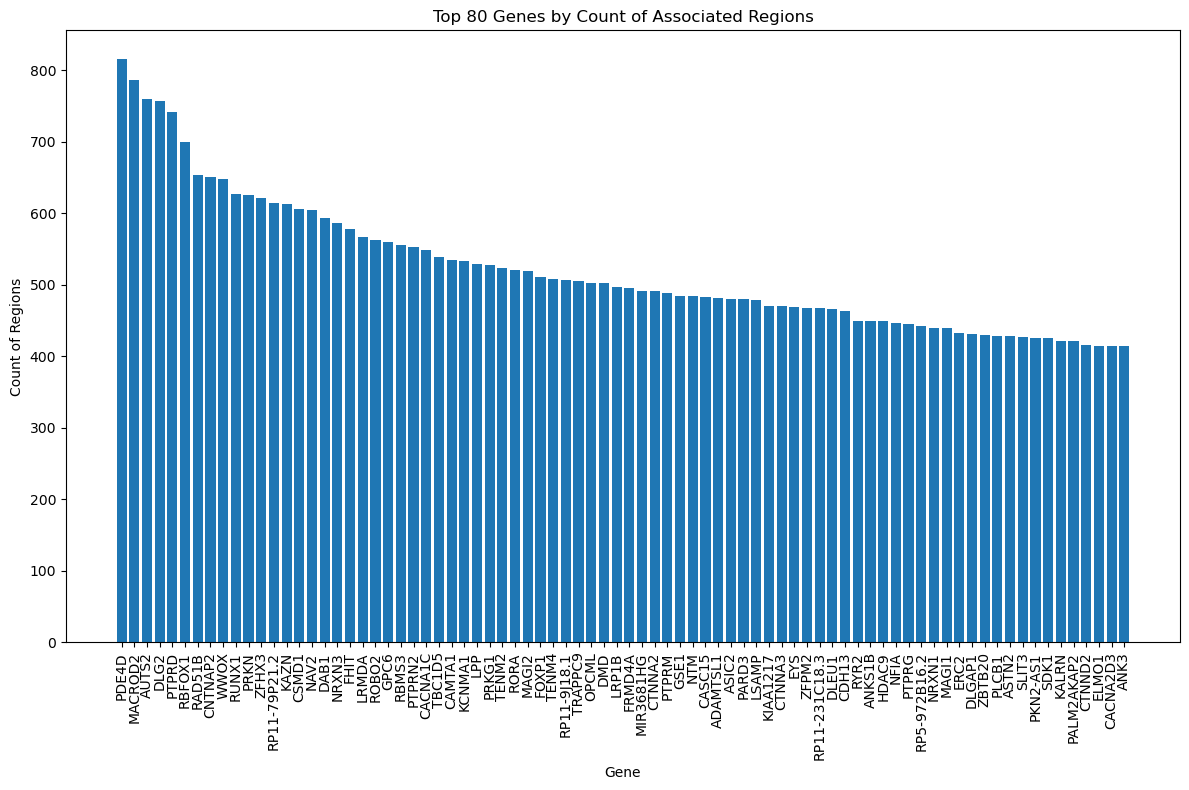

In [67]:
top_n = 80
gene_counts_sorted = gene_counts.sort_values(by="region_count", ascending=False).head(top_n)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(gene_counts_sorted.index, gene_counts_sorted["region_count"])
plt.xticks(rotation=90)
plt.xlabel("Gene")
plt.ylabel("Count of Regions")
plt.title(f"Top {top_n} Genes by Count of Associated Regions")
plt.tight_layout()
plt.show()

The plot is almost the same as before. We did not change the amount of annotated regions significantly, but the chromosome where they are annotated!

### 7.3. Plot Distribution (Histogram) of region_count per gene_annotation

<Figure size 1200x600 with 0 Axes>

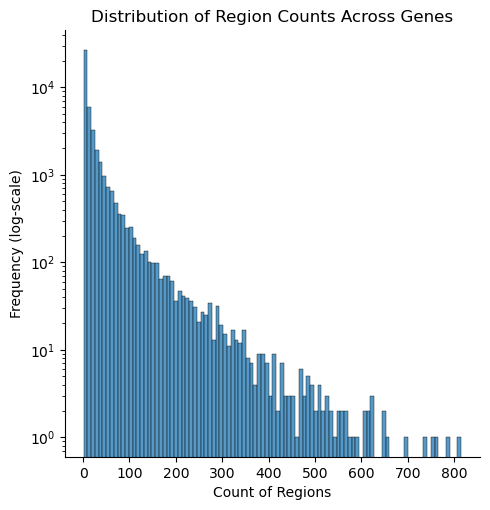

In [68]:
plt.figure(figsize=(12, 6))
sns.displot(gene_counts["region_count"], kind='hist', log_scale=(False, True), bins=100)
plt.xlabel("Count of Regions")
plt.ylabel("Frequency (log-scale)")
plt.title("Distribution of Region Counts Across Genes")
plt.show()

Also almost the same!

## 8. Test different settings of upstream/downstream to cover most regions, but not overlap with too much genes at the same time.

To test for different parameters for upstream and downstream we want to see a good coverage with a low overlap.

Coverage: The number of regions annotated with at least one gene.

Overlap: The number of regions annotated with at least two genes.

%%time
for upstream in [0, 500, 1000, 2000, 5000, 10000, 20000]:
    for downstream in [0, 500, 1000, 2000, 5000, 10000, 20000]:
        for annotation in ["HAVANA", "ENSEMBL"]:
            my_find_genes(adata,
                    gtf_file=f"{data_folder}/{gtf_filename}",
                    key_added=f'gene_annotation_{annotation}_{upstream}_{downstream}',
                    upstream=upstream,
                    downstream=downstream,
                    feature_type='gene',
                    annotation=annotation)

This would be very painful with the slower find_genes.

def calculate_metrics(adata, column_names):
    tidy_data = []

    for col in column_names:
        if col in adata.var.columns:
            # Extract annotation, upstream, and downstream from column name
            annotation, upstream, downstream = col.split('_')[2:]  # Adjust the indices based on your column name format

            # Split the gene annotations and count the number of genes per region, excluding 'intergenic' or 'unassigned'
            gene_counts = adata.var[col].str.split(';').apply(lambda x: len([gene for gene in x if gene not in ['intergenic', 'unassigned']]) if isinstance(x, list) else 0)

            # Calculate coverage
            coverage = (gene_counts > 0).sum()

            # Calculate overlap
            overlap = (gene_counts > 1).sum()

            # Accumulate the data
            tidy_data.append({'upstream': upstream, 'downstream': downstream, 'annotation': annotation, 'metric': 'coverage', 'value': coverage})
            tidy_data.append({'upstream': upstream, 'downstream': downstream, 'annotation': annotation, 'metric': 'overlap', 'value': overlap})
        else:
            print(f"Column '{col}' not found in adata.var")

    tidy_df = pd.DataFrame(tidy_data)

    return tidy_df

%%time
col_names = []
for upstream in [0, 500, 1000, 2000, 5000, 10000, 20000]:
    for downstream in [0, 500, 1000, 2000, 5000, 10000, 20000]:
        for annotation in ["HAVANA", "ENSEMBL"]:
            col_names.append(f'gene_annotation_{annotation}_{upstream}_{downstream}')

metrics_df = calculate_metrics(adata, col_names)

metrics_df

# Filter for HAVANA and ENSEMBL annotations
havana_df = metrics_df[metrics_df['annotation'] == 'HAVANA']
ensembl_df = metrics_df[metrics_df['annotation'] == 'ENSEMBL']

# Function to calculate the ratio and reshape for heatmap
def prepare_heatmap_data(df):
    # Pivot table to create a matrix of upstream (rows) and downstream (columns)
    coverage = df[df['metric'] == 'coverage'].pivot(index='upstream', columns='downstream', values='value')
    overlap = df[df['metric'] == 'overlap'].pivot(index='upstream', columns='downstream', values='value')

    # Calculate the ratio and handle division by zero
    ratio = coverage - overlap
    ratio.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN

    return ratio

# Prepare data for heatmaps
havana_heatmap_data = prepare_heatmap_data(havana_df)
ensembl_heatmap_data = prepare_heatmap_data(ensembl_df)

# Convert 'upstream' and 'downstream' to integers for sorting
havana_heatmap_data.index = havana_heatmap_data.index.astype(int)
havana_heatmap_data.columns = havana_heatmap_data.columns.astype(int)
ensembl_heatmap_data.index = ensembl_heatmap_data.index.astype(int)
ensembl_heatmap_data.columns = ensembl_heatmap_data.columns.astype(int)

# Sort the index and columns
havana_heatmap_data = havana_heatmap_data.sort_index().sort_index(axis=1)
ensembl_heatmap_data = ensembl_heatmap_data.sort_index().sort_index(axis=1)

havana_heatmap_data

# Function to plot heatmap
def plot_heatmap(data, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(data, annot=True, fmt=".4f", cmap='viridis', annot_kws={"size": 7})
    plt.title(title)
    plt.ylabel('Upstream')
    plt.xlabel('Downstream')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# Plot heatmaps for HAVANA and ENSEMBL
plot_heatmap(havana_heatmap_data, 'HAVANA Coverage/Overlap Ratio')
plot_heatmap(ensembl_heatmap_data, 'ENSEMBL Coverage/Overlap Ratio')

- TODO plot all the relevant Heatmaps/whatever one after the other, instead of relying on changing the cells above.
- TODO properly rewrite this conclusion

We see that HAVANA has way better coverage than ENSEMBLE. Thus we drop ENSEMBLE for now.

In general coverage and overlap increase as we either increase upstream or downstream.

Increasing upstream is a little better for not increasing overlap, while also being better for increasing coverage.
But the ratio of coverage/overlap is better if we increase upstream, rather than downstream. Thus we want to increase upstream a little over downstream.

We want a good coverage, of most regions, while keeping the overlap managable. I suppose the following steps have a much harder time diffentiating between different cells, if too many genes overlap.

For now: we choose HAVANA upstream 5000 and downstream 2000 as our default gene_annotation.
It has a good coverage of 849K, in the midst between HAVANA,0,0 (796K) and HAVANA,20000,20000 (992K), while at the same time only having an overlap of 186K, which is not much worse than HAVANA,0,0 (108K) but way better than HAVANA,20000,20000 (493K)

The best ratio of coverage/overlap is at 0,0 while the best difference coverage - overlap is at 0,1000

adata